## Quantatative Investment Project

### Team Member: Yijie Liu, Muhan Xia, Xiangyu Huang(xhuang16)
**Abstract:** 
In this report, we will demonstrate a quantitative approach by combining momentum and reversal strategy to long the selected stocks with a daily basis and achieve excess return. 

**Data Set Information:**
The data is from the WRSD website (https://wrds-www.wharton.upenn.edu). The CRSP U.S. Stock database contains end-of-day and month-end prices on primary listings for the NYSE, NYSE MKT, NASDAQ, and Arca exchanges, along with basic market indices. CRSP databases are characterized by their comprehensive corporate action information and highly accurate total return calculations. 

### Project Description:
We believe that if a stock price is stable and has neither upside nor downside momentum, the reversal strategy would be most effective because prices would probably go back up to original price levels after some indications of decline in stock price. In the notebook, we will demonstrate the rate of return of our strategy. We use quntile method to classify stocks into groups and select the group according to our strategy above. We use data from 2000 - 2010 to build our strategy and test with 2010-2018 data.

Comments and Explanations (in the form of Markdown) are included in the notebook to improve the readability of the code, to explain the rationale of doing certain steps and to discuss the results and inferences from the executed code.

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn

In [31]:
data = pd.read_feather("data_test.feather")

first_date = '2000-01-01'
last_date  = '2010-12-31'
data = data.loc[(data['DATE']>=first_date) & (data['DATE']<=last_date)]
## We want to apply our method for the 2000-2010. And we will test if it's working for during 2010-2020.  

data['MV'] = data['SHROUT'] * np.abs(data['OPENPRC'])
## Our strategy will be computed at the beginning of the days, 
## so We apply the Market Value as MV by computing share outstanding * openning price.

data['XRET'] = data['RET'] 
data = data.drop(['TICKER','OPENPRC','BID','ASK', 'ASKHI', 'BIDLO', 'NUMTRD', 'RET', 'SHROUT'],axis=1)

data = data.sort_values(by = ['PERMNO','DATE'])
data = data.groupby(['PERMNO','DATE']).tail(1)
data.set_index(['PERMNO','DATE'], inplace=True)
data.sort_index(inplace=True)
data

PRC        VOL    SPRTRN            MV      XRET
PERMNO  DATE                                                              
10001.0 2000-01-03   8.562500     1721.0 -0.009549  2.067188e+04  0.007353
        2000-01-04   8.437500     1080.0 -0.038345  2.067188e+04 -0.014599
        2000-01-05   8.562500     1711.0  0.001922  2.067188e+04  0.014815
        2000-01-06   8.500000      580.0  0.000956  2.082500e+04 -0.007299
        2000-01-07   8.437500     1406.0  0.027090  2.097812e+04 -0.007353
...                       ...        ...       ...           ...       ...
93436.0 2010-12-27  25.549000  9407934.0  0.000613  2.613453e+06 -0.150914
        2010-12-28  26.410000  4107002.0  0.000771  2.411055e+06  0.033700
        2010-12-29  27.730000  3363184.0  0.001009  2.521115e+06  0.049981
        2010-12-30  26.500000  2063322.0 -0.001508  2.583607e+06 -0.044356
        2010-12-31  26.629999  1429604.0 -0.000191  2.521706e+06  0.004906

[19874551 rows x 5 columns]

 - In the following cell, we will build some variables including momentum index, moving average index and information discreteness index. We will use quntile groups based on these index to illustrate our strategy.

In [32]:
data['LAG_VOL'] = data.groupby('PERMNO')['VOL'].shift()
## Volume Lag for screening.
## We are aiming at low market value stocks, thus some of these stocks are extremely involatile 
## We want to make sure that there are some levels of trading volumes before we apply our strategy


minlag = 22  
maxlag = 88
data['CUMGROSSRET'] = (1+data['XRET']).groupby('PERMNO').cumprod()
data['MOMENTUM'] = data['CUMGROSSRET'].groupby('PERMNO').shift(minlag) / data['CUMGROSSRET'].groupby('PERMNO').shift(maxlag) - 1
## We will use the period from 4 month (88 trading days) ago to 1 month (22 trading days) ago to check momentum
## We use the cumulative gross return to get our momentum index.


data['MA'] = data.groupby('PERMNO')['XRET'].rolling(10).mean().shift().reset_index(0,drop = True) 
## We use the previous two weeks (10 trading days) moving average to check if the reversal appears. 


data['UP'] = 0
data['UP'].loc[data['XRET'] >= 0] = 1
data['DIFT'] = data.groupby('PERMNO')['UP'].rolling(230).mean().shift(22).reset_index(0,drop = True)
data['ID'] = (1+data['MOMENTUM'])*(1-2*data['DIFT'])
## We apply the formula of information discreteness

data.head(5)

/Users/sky/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PRC     VOL    SPRTRN         MV      XRET  LAG_VOL  \
PERMNO  DATE                                                                 
10001.0 2000-01-03  8.5625  1721.0 -0.009549  20671.875  0.007353      NaN   
        2000-01-04  8.4375  1080.0 -0.038345  20671.875 -0.014599   1721.0   
        2000-01-05  8.5625  1711.0  0.001922  20671.875  0.014815   1080.0   
        2000-01-06  8.5000   580.0  0.000956  20825.000 -0.007299   1711.0   
        2000-01-07  8.4375  1406.0  0.027090  20978.125 -0.007353    580.0   

                    CUMGROSSRET  MOMENTUM  MA  UP  DIFT  ID  
PERMNO  DATE                                                 
10001.0 2000-01-03     1.007353       NaN NaN   1   NaN NaN  
        2000-01-04     0.992647       NaN NaN   0   NaN NaN  
        2000-01-05     1.007353       NaN NaN   1   NaN NaN  
        2000-01-06     1.000000       NaN NaN   0   NaN NaN  
        2000-01-07     0.992647       NaN NaN   0   NaN NaN

In [33]:
## To manipulate our data into time sequnce structure, we reset the index order.
data_2 = data.reorder_levels(['DATE','PERMNO'])
data_2.sort_index(inplace=True)
data_2.dropna(inplace=True)
data_2.head()
data_2

PRC       VOL    SPRTRN            MV      XRET  \
DATE       PERMNO                                                           
2000-12-29 10001.0   9.750000    2104.0 -0.010448  2.404325e+04  0.012987   
           10012.0   2.000000  684329.0 -0.010448  4.170331e+04 -0.058824   
           10016.0  22.375000   35455.0 -0.010448  3.954732e+05 -0.040214   
           10019.0   3.500000  435839.0 -0.010448  1.964125e+04  0.435897   
           10025.0  44.687500   18500.0 -0.010448  3.410679e+05 -0.006944   
...                       ...       ...       ...           ...       ...   
2010-12-31 93192.0   5.670000   30368.0 -0.000191  2.863560e+05 -0.029110   
           93193.0   3.790000   95842.0 -0.000191  1.918246e+04  0.035519   
           93194.0   8.710000  266417.0 -0.000191  1.294964e+05  0.031991   
           93195.0   3.780000    2100.0 -0.000191  5.331750e+04  0.010695   
           93223.0  52.060001  151600.0 -0.000191  2.764365e+06 -0.020324   

                     LAG_VOL  CUMGROSSRET  MOMENTUM        MA  UP      DIFT  \
DATE       PERMNO                                                             
2000-12-29 10001.0    1600.0     1.215636  0.168806  0.000067   1  0.639130   
           10012.0  263678.0     0.249027 -0.568421 -0.047530   0  0.469565   
           10016.0   16319.0     1.185430  0.190436  0.001246   0  0.534783   
           10019.0   47793.0     0.347826 -0.138889 -0.002867   1  0.526087   
           10025.0   19500.0     1.735437  0.418259  0.000016   0  0.600000   
...                      ...          ...       ...       ...  ..       ...   
2010-12-31 93192.0   88322.0     0.821739 -0.237437  0.007933   0  0.469565   
           93193.0   44775.0     0.437140 -0.226415  0.007749   1  0.482609   
           93194.0  373906.0     0.034495 -0.511879  0.000937   1  0.391304   
           93195.0    1599.0     0.757515  0.301003  0.001396   1  0.526087   
           93223.0   89300.0     1.047856  0.120054  0.002884   0  0.504348   

                          ID  
DATE       PERMNO             
2000-12-29 10001.0 -0.325233  
           10012.0  0.026270  
           10016.0 -0.082813  
           10019.0 -0.044928  
           10025.0 -0.283652  
...                      ...  
2010-12-31 93192.0  0.046417  
           93193.0  0.026907  
           93194.0  0.106113  
           93195.0 -0.067878  
           93223.0 -0.009740  

[15624615 rows x 12 columns]

In [34]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

data_2['QUINTILE_mv'] = data_2['MV'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_mom'] = data_2['MOMENTUM'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_ma'] = data_2['MA'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_id'] = data_2['ID'].groupby('DATE').apply(quintiles)
data_2

## We use the quintiles approach to divide all our parameters into 5 subgroups. 

PRC       VOL    SPRTRN            MV      XRET  \
DATE       PERMNO                                                           
2000-12-29 10001.0   9.750000    2104.0 -0.010448  2.404325e+04  0.012987   
           10012.0   2.000000  684329.0 -0.010448  4.170331e+04 -0.058824   
           10016.0  22.375000   35455.0 -0.010448  3.954732e+05 -0.040214   
           10019.0   3.500000  435839.0 -0.010448  1.964125e+04  0.435897   
           10025.0  44.687500   18500.0 -0.010448  3.410679e+05 -0.006944   
...                       ...       ...       ...           ...       ...   
2010-12-31 93192.0   5.670000   30368.0 -0.000191  2.863560e+05 -0.029110   
           93193.0   3.790000   95842.0 -0.000191  1.918246e+04  0.035519   
           93194.0   8.710000  266417.0 -0.000191  1.294964e+05  0.031991   
           93195.0   3.780000    2100.0 -0.000191  5.331750e+04  0.010695   
           93223.0  52.060001  151600.0 -0.000191  2.764365e+06 -0.020324   

                     LAG_VOL  CUMGROSSRET  MOMENTUM        MA  UP      DIFT  \
DATE       PERMNO                                                             
2000-12-29 10001.0    1600.0     1.215636  0.168806  0.000067   1  0.639130   
           10012.0  263678.0     0.249027 -0.568421 -0.047530   0  0.469565   
           10016.0   16319.0     1.185430  0.190436  0.001246   0  0.534783   
           10019.0   47793.0     0.347826 -0.138889 -0.002867   1  0.526087   
           10025.0   19500.0     1.735437  0.418259  0.000016   0  0.600000   
...                      ...          ...       ...       ...  ..       ...   
2010-12-31 93192.0   88322.0     0.821739 -0.237437  0.007933   0  0.469565   
           93193.0   44775.0     0.437140 -0.226415  0.007749   1  0.482609   
           93194.0  373906.0     0.034495 -0.511879  0.000937   1  0.391304   
           93195.0    1599.0     0.757515  0.301003  0.001396   1  0.526087   
           93223.0   89300.0     1.047856  0.120054  0.002884   0  0.504348   

                          ID QUINTILE_mv QUINTILE_mom QUINTILE_ma QUINTILE_id  
DATE       PERMNO                                                              
2000-12-29 10001.0 -0.325233           2            5           3           1  
           10012.0  0.026270           2            1           1           5  
           10016.0 -0.082813           4            5           3           3  
           10019.0 -0.044928           2            3           3           3  
           10025.0 -0.283652           4            5           3           1  
...                      ...         ...          ...         ...         ...  
2010-12-31 93192.0  0.046417           3            1           5           5  
           93193.0  0.026907           1            1           5           5  
           93194.0  0.106113           2            1           2           5  
           93195.0 -0.067878           1            5           3           3  
           93223.0 -0.009740           5            3           3           4  

[15624615 rows x 16 columns]

In [35]:
ports = data_2.loc[ (data_2['QUINTILE_ma'] == 1) & 
                 (data_2['QUINTILE_mom'] == 3) & 
                 (data_2['QUINTILE_mv'] == 1) & 
                 (data_2['QUINTILE_id'] == 1) &  
                 (data_2['LAG_VOL'] >= 5000), ].groupby('DATE')['XRET'].mean()

ports.mean() ## Average Daily Rate of Return 

0.010584410965484256

In [36]:
(ports.mean() / ports.std())  ## Sharpe Ratio

0.19205136125934955

 - Our Result shows an extraordinary return and sharpe ratio for each day. However, in somedays, our strategy doesn't make any trade. Thus, we will take the following steps to change those days to 0 and output an annual return.

In [37]:
data_3 = data_2.reset_index(1,drop = True)
df_result = data_3.groupby('DATE')['XRET'].mean()
df_result = df_result.to_frame()
ports_2 = ports.to_frame()

df_result['S&P Ret'] = data.groupby('DATE')['SPRTRN'].mean()
df_result['OUR_RET'] = ports_2['XRET']
df_result['OUR_RET'] = df_result['OUR_RET'].fillna(0)
df_result['OUR_RET'].mean()  ## Avg Return after penalizing for the no-trade days

0.009970212236962515

In [38]:
(df_result['OUR_RET'].mean() / df_result['OUR_RET'].std()) * np.sqrt(250) ## Sharpe Ratio

2.944063044793323

 - Even after we fill no trade days with 0 return, our strategy still shows about 0.58% daily return on average. And have an annual sharpe ratio around 2.5 

### Visualization: 
The following plots are some visualizations of our results. 

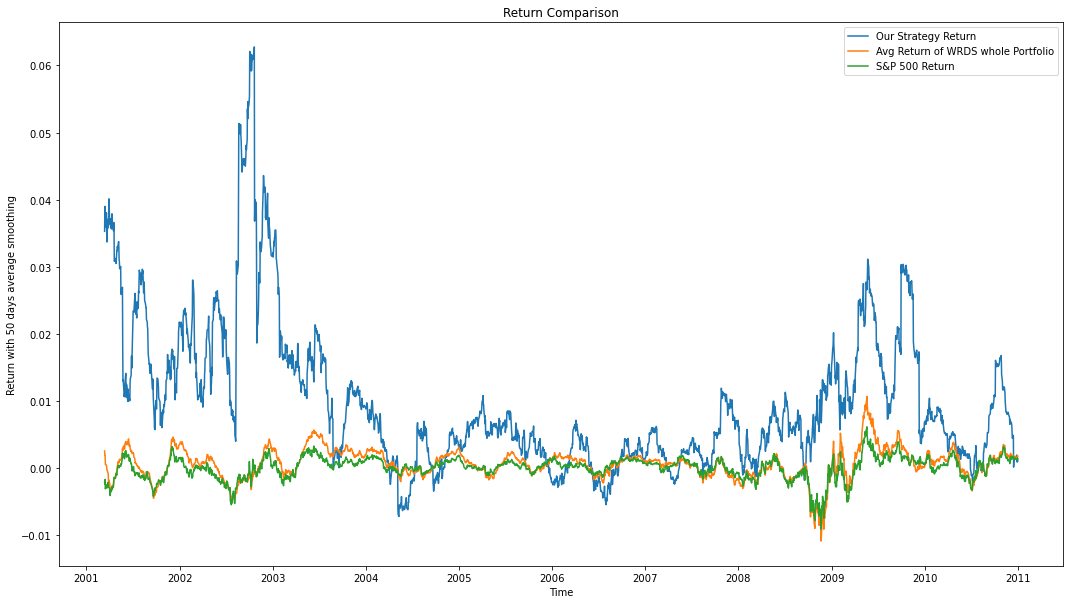

In [39]:
plt.figure(figsize=(18,10))
plt.title("Return Comparison")
plt.xlabel('Time')
plt.ylabel('Return with 50 days average smoothing')
plt.plot(df_result['OUR_RET'].rolling(50).mean(), label = "Our Strategy Return")
plt.plot(df_result['XRET'].rolling(50).mean(), label = "Avg Return of WRDS whole Portfolio")
plt.plot(df_result['S&P Ret'].rolling(50).mean(), label = "S&P 500 Return")
plt.legend()
plt.show()

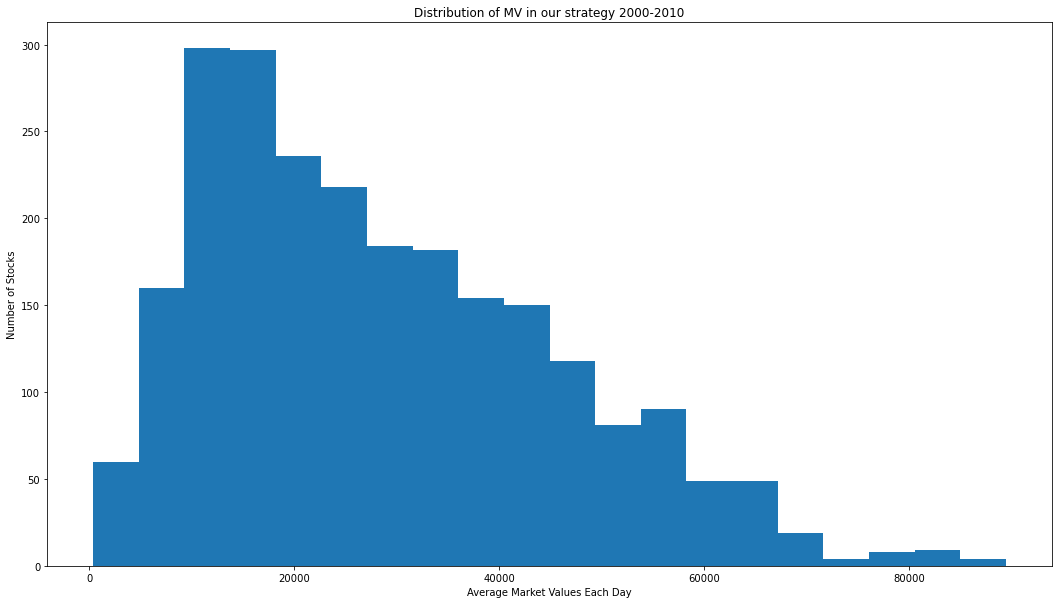

In [40]:
df_for_plot = data_2.loc[ (data_2['QUINTILE_ma'] == 1) & 
                 (data_2['QUINTILE_mom'] == 3) & 
                 (data_2['QUINTILE_mv'] == 1) & 
                 (data_2['QUINTILE_id'] == 1) &  
                 (data_2['LAG_VOL'] >= 5000), ].groupby('DATE').mean()

plt.figure(figsize=(18,10))
plt.hist(df_for_plot['MV'],bins=20)
plt.title("Distribution of MV in our strategy 2000-2010")
plt.xlabel('Average Market Values Each Day')
plt.ylabel('Number of Stocks')
plt.show()

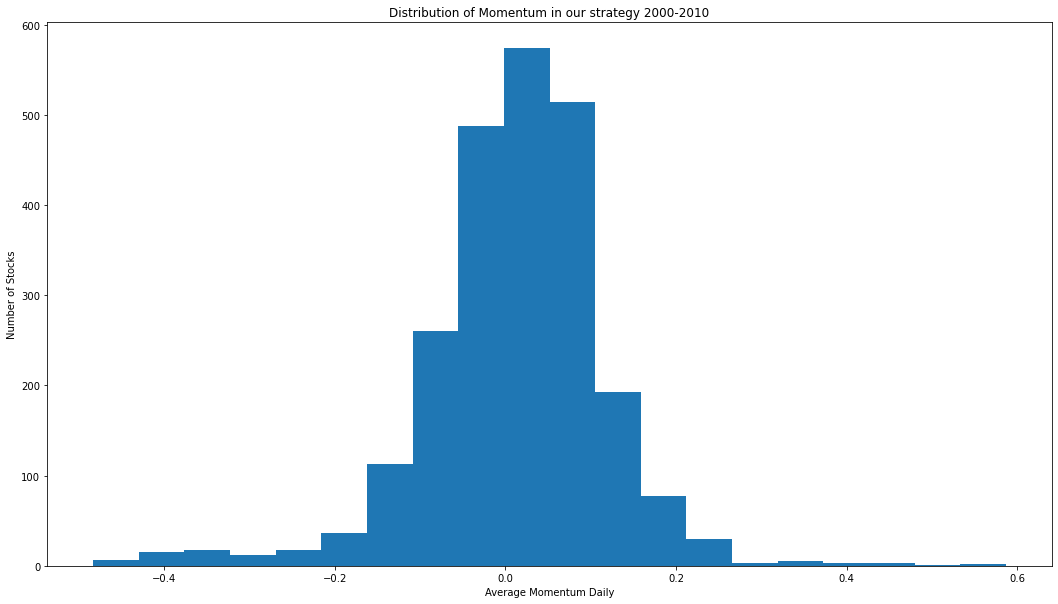

In [41]:
plt.figure(figsize=(18,10))
plt.hist(df_for_plot['MOMENTUM'],bins=20)
plt.title("Distribution of Momentum in our strategy 2000-2010")
plt.xlabel('Average Momentum Daily')
plt.ylabel('Number of Stocks')
plt.show()

 - In the following steps, we will check if our method works for 2010-2020. 

In [42]:
data = pd.read_feather("data_test.feather")

first_date = '2010-01-01'
last_date  = '2020-12-31'
data = data.loc[(data['DATE']>=first_date) & (data['DATE']<=last_date)]

data['MV'] = data['SHROUT'] * np.abs(data['OPENPRC'])
data['XRET'] = data['RET'] 
data = data.drop(['TICKER','OPENPRC','BID','ASK', 'ASKHI', 'BIDLO', 'NUMTRD', 'RET', 'SHROUT'],axis=1)

data = data.sort_values(by = ['PERMNO','DATE'])
data = data.groupby(['PERMNO','DATE']).tail(1)
data.set_index(['PERMNO','DATE'], inplace=True)
data.sort_index(inplace=True)

data['LAG_VOL'] = data.groupby('PERMNO')['VOL'].shift()

minlag = 22  
maxlag = 88
data['CUMGROSSRET'] = (1+data['XRET']).groupby('PERMNO').cumprod()
data['MOMENTUM'] = data['CUMGROSSRET'].groupby('PERMNO').shift(minlag) / data['CUMGROSSRET'].groupby('PERMNO').shift(maxlag) - 1
data['MA'] = data.groupby('PERMNO')['XRET'].rolling(10).mean().shift().reset_index(0,drop = True) 
data['UP'] = 0
data['UP'].loc[data['XRET'] >= 0] = 1
data['DIFT'] = data.groupby('PERMNO')['UP'].rolling(230).mean().shift(22).reset_index(0,drop = True)
data['ID'] = (1+data['MOMENTUM'])*(1-2*data['DIFT'])
data.head(5)

/Users/sky/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PRC      VOL    SPRTRN            MV      XRET  LAG_VOL  \
PERMNO  DATE                                                                    
10001.0 2010-01-04  10.25  18500.0  0.016043  46139.379667 -0.004854      NaN   
        2010-01-05  10.19  23200.0  0.003116  44394.981331 -0.005854  18500.0   
        2010-01-06  10.31  18700.0  0.000546  44394.981331  0.011776  23200.0   
        2010-01-07   9.96  29200.0  0.004001  44831.078835 -0.033948  18700.0   
        2010-01-08  10.34  25100.0  0.002882  43610.000000  0.038153  29200.0   

                    CUMGROSSRET  MOMENTUM  MA  UP  DIFT  ID  
PERMNO  DATE                                                 
10001.0 2010-01-04     0.995146       NaN NaN   0   NaN NaN  
        2010-01-05     0.989320       NaN NaN   0   NaN NaN  
        2010-01-06     1.000971       NaN NaN   1   NaN NaN  
        2010-01-07     0.966990       NaN NaN   0   NaN NaN  
        2010-01-08     1.003883       NaN NaN   1   NaN NaN

In [ ]:
## To manipulate our data into time sequnce structure, we reset the index order.
data_2 = data.reorder_levels(['DATE','PERMNO'])
data_2.sort_index(inplace=True)
data_2.dropna(inplace=True)
data_2['QUINTILE_mv'] = data_2['MV'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_mom'] = data_2['MOMENTUM'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_ma'] = data_2['MA'].groupby('DATE').apply(quintiles)
data_2['QUINTILE_id'] = data_2['ID'].groupby('DATE').apply(quintiles)

In [ ]:
ports = data_2.loc[ (data_2['QUINTILE_ma'] == 1) & 
                 (data_2['QUINTILE_mom'] == 3) & 
                 (data_2['QUINTILE_mv'] == 1) & 
                 (data_2['QUINTILE_id'] == 1) &  
                 (data_2['LAG_VOL'] >= 5000), ].groupby('DATE')['XRET'].mean()

ports.mean()

In [ ]:
ports.mean() / ports.std()

In [ ]:
data_3 = data_2.reset_index(1,drop = True)
df_result = data_3.groupby('DATE')['XRET'].mean()
df_result = df_result.to_frame()
ports_2 = ports.to_frame()

df_result['S&P Ret'] = data.groupby('DATE')['SPRTRN'].mean()
df_result['OUR_RET'] = ports_2['XRET']
df_result['OUR_RET'] = df_result['OUR_RET'].fillna(0)
df_result['OUR_RET'].mean()

In [ ]:
(df_result['OUR_RET'].mean() / df_result['OUR_RET'].std()) * np.sqrt(250)

### Visualization: 

In [ ]:
plt.figure(figsize=(18,10))
plt.title("Return Comparison")
plt.xlabel('Time')
plt.ylabel('Return with 50 days average smoothing')
plt.plot(df_result['OUR_RET'].rolling(50).mean(), label = "Our Strategy Return")
plt.plot(df_result['XRET'].rolling(50).mean(), label = "Avg Return of WRDS whole Portfolio")
plt.plot(df_result['S&P Ret'].rolling(50).mean(), label = "S&P 500 Return")
plt.legend()
plt.show()

In [ ]:
df_for_plot = data_2.loc[ (data_2['QUINTILE_ma'] == 1) & 
                 (data_2['QUINTILE_mom'] == 3) & 
                 (data_2['QUINTILE_mv'] == 1) & 
                 (data_2['QUINTILE_id'] == 1) &  
                 (data_2['LAG_VOL'] >= 5000), ].groupby('DATE').mean()

plt.figure(figsize=(18,10))
plt.hist(df_for_plot['MV'],bins=20)
plt.title("Distribution of MV in our strategy 2010-2020")
plt.xlabel('Average Market Values Each Day')
plt.ylabel('Number of Stocks')
plt.show()

In [ ]:
plt.figure(figsize=(18,10))
plt.hist(df_for_plot['MOMENTUM'],bins=20)
plt.title("Distribution of Momentum in our strategy 2010-2020")
plt.xlabel('Average Momentum Daily')
plt.ylabel('Number of Stocks')
plt.show()

 - Our strategy yield extremely high return with higher variations.